# Food-101 Image dataset cleaning using Fastdup pipeline

## Importing library

In [ ]:
#To install fastdup if not already in your system
# !pip3 install fastdup 

In [1]:
import fastdup
fastdup.__version__

/Users/arpansharma/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'2.13'

In [4]:
import pandas as pd
import os
from collections import defaultdict
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
import math
import json
from pathlib import Path

## Preparing Data

* In case you are using this notebook in kaggle
    - Go to https://www.kaggle.com/datasets/arpanshrma17/detect-food-101
    - Upload this dataset to your runtime input.
* In case you are using this notebook in local system
    - Download the dataset from Kaggle website to your local system.
        - Go to https://www.kaggle.com/datasets/arpanshrma17/detect-food-101
        - Click the "Download" button (you'll need to be logged into Kaggle)
        - The dataset will download as a zip file
        - Unzip it to your desired location using Mac's built-in unzip tool or Archive Utility
* In case you are using this on google colab:
  - You need to authenticate to your kaggle account using Kaggle’s public API.
  - In order to use the Kaggle’s public API, you must first authenticate using an API token. Go to the 'Account' tab of your user profile and select 'Create New Token'. This will trigger the download of kaggle.json, a file containing your API credentials.
  - Then, use this code chunk.
  ```
  import os
  import kaggle
  from pathlib import Path
  from google.colab import files  # Needed if using Google Colab
  # If you're using Google Colab, upload your kaggle.json file
  # Uncomment these lines if using Colab:
  # files.upload()  # This will prompt you to upload kaggle.json
  # !mkdir -p ~/.kaggle
  # !cp kaggle.json ~/.kaggle/
  # !chmod 600 ~/.kaggle/kaggle.json

  # Create a directory for the dataset
  save_path = './food101_dataset'
  save_dir = Path(save_path)
  save_dir.mkdir(parents=True, exist_ok=True)

  # Download the dataset
  print(f"Downloading Food-101 dataset to {save_path}...")
  kaggle.api.dataset_download_files(
      'arpanshrma17/detect-food-101',
      path=save_path,
      unzip=True
  )

  print("Download completed successfully!")
```

In [2]:
data_dir = 'Dataset/FOOD_data/' #<-----Replace with your actual path

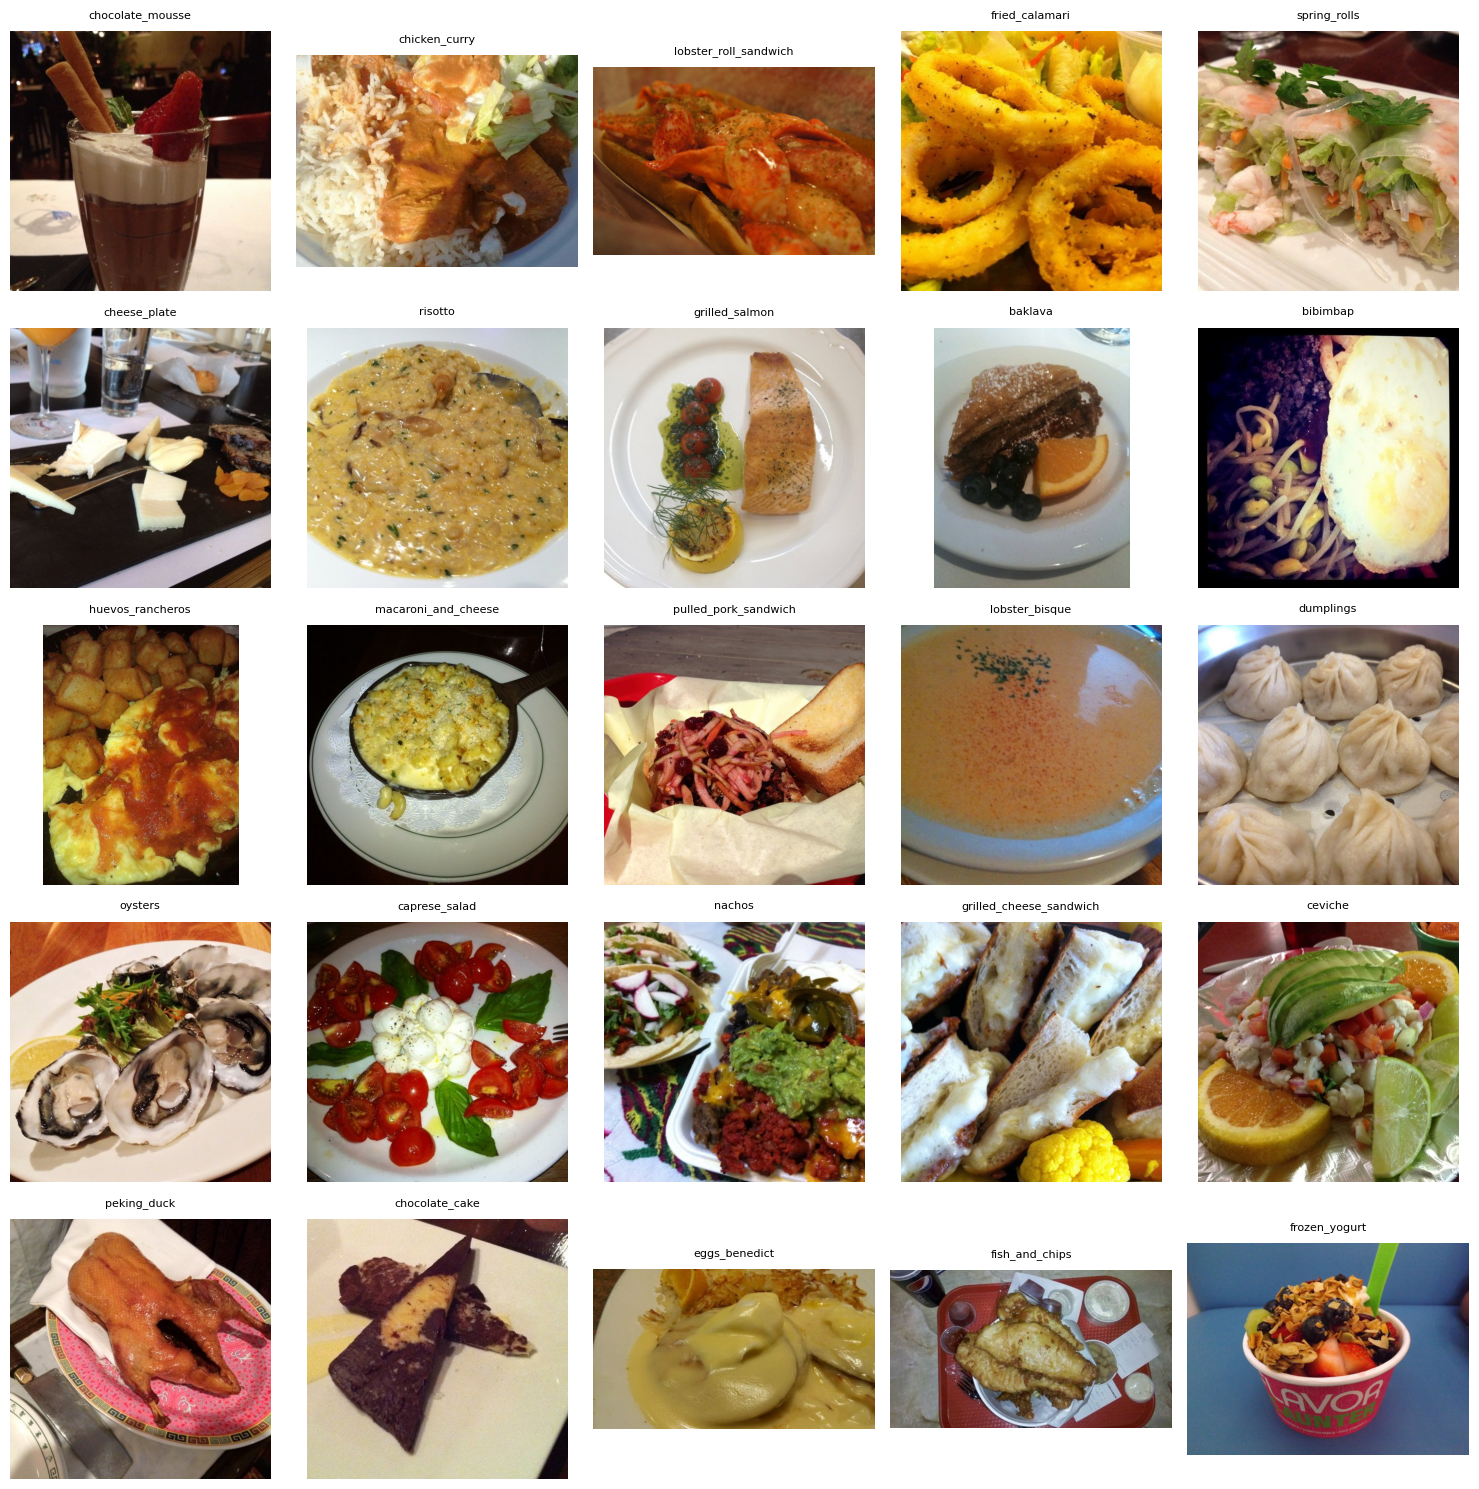

In [5]:
def display_food_images(base_path, num_categories=25):
    """
    Display a grid of food images with one image from each category
    
    Parameters:
    base_path: str - Path to the main data directory (train/test/val)
    num_categories: int - Number of different food categories to display
    """
    
    # Get list of food categories
    categories = os.listdir(base_path)
    
    # Randomly select categories if there are more than requested
    if len(categories) > num_categories:
        categories = random.sample(categories, num_categories)
    
    # Calculate grid dimensions (trying to make it as square as possible)
    grid_size = math.ceil(math.sqrt(num_categories))
    
    # Create figure
    fig = plt.figure(figsize=(15, 15))
    # fig.suptitle('Food-101 Dataset: One Sample per Category', fontsize=16)
    
    # For each category
    for idx, category in enumerate(categories):
        category_path = os.path.join(base_path, category)
        images = os.listdir(category_path)
        
        # Randomly select one image
        img_name = random.choice(images)
        img_path = os.path.join(category_path, img_name)
        
        # Add subplot
        plt.subplot(grid_size, grid_size, idx + 1)
        
        # Read and display image
        try:
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'{category}', pad=10, fontsize=8)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    
    plt.tight_layout()
    plt.show()

# usage:
data_path = data_dir+"/train"  # or /test or /val

# Display grid of images
display_food_images(
    base_path=data_path,
    num_categories=25  # Number of different food categories to display
)

- creating Label annotation for data set

In [ ]:
def create_annotation_df(base_path):
    """
    Create a DataFrame containing image annotations from a hierarchical dataset structure.
    
    Parameters:
    base_path: str - Path to the main data directory containing train/val/test folders
    
    Returns:
    pandas.DataFrame with columns: filename, label, split
    """
    
    # Lists to store data
    filenames = []
    labels = []
    splits = []
    
    # Process each split (train/val/test)
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(base_path, 'FOOD_data', split)
        
        # Check if the split directory exists
        if not os.path.exists(split_path):
            print(f"Warning: {split} directory not found at {split_path}")
            continue
            
        # Process each category folder
        for category in os.listdir(split_path):
            category_path = os.path.join(split_path, category)
            
            # Skip if not a directory
            if not os.path.isdir(category_path):
                continue
                
            # Process each image in the category
            for image_file in os.listdir(category_path):
                # Create full file path
                file_path = os.path.join(category_path, image_file)
                
                # Add to lists
                filenames.append(file_path)
                labels.append(category)
                splits.append(split)
    
    # Create DataFrame
    df = pd.DataFrame({
        'filename': filenames,
        'label': labels,
        'split': splits
    })
    
    # Convert paths to relative paths if needed
    # df['filename'] = df['filename'].apply(lambda x: str(Path(x).relative_to(base_path)))
    
    return df

# Example usage:
base_path = "Dataset"  # Replace with your dataset root directory

# Create the DataFrame
df = create_annotation_df(base_path)

# Display first few rows and basic information
print("\nFirst few rows of the DataFrame:")
print(df.head())

print("\nDataset statistics:")
print(f"Total number of images: {len(df)}")
print("\nImages per split:")
print(df['split'].value_counts())
print("\nNumber of unique categories:", df['label'].nunique())

# Optional: Save to CSV
df.to_csv('food101_annotations.csv', index=False)

In [ ]:
csv_path = 'food101_annotations.csv'

In [66]:
df_annot = pd.read_csv(csv_path)
df_annot.head(3)

filename      label  split
0  Dataset/FOOD_data/train/foie_gras/2686450.jpg  foie_gras  train
1  Dataset/FOOD_data/train/foie_gras/2080246.jpg  foie_gras  train
2  Dataset/FOOD_data/train/foie_gras/1891930.jpg  foie_gras  train

## Run fastdup
### create a `fastdup` object and specify the input directory which points to the folder of images.
- running fastdup on the entire dataset

Threshold for Similarity clusters
Default: cc_threshold=0.96
The ccthreshold parameter controls the distance used for determining whether two image belong to the same similarity cluster, calculated using Connected components algorithm.

The best threshold depends on both data and use case:
A higher threshold would cluster images that are highly similar and even duplicates, but would cluster less images.
A lower threshold would cluster more similar images together, but clusters would have more diversity and a larger possible difference between images.

reference : https://visual-layer.readme.io/docs/tuning-run-parameters#threshold-for-similarity-clusters

In [12]:
fd = fastdup.create(input_dir=data_dir) 
fd.run(annotations=df_annot, ccthreshold=0.9, threshold=0.8)

fastdup By Visual Layer, Inc. 2024. All rights reserved.



fastdup By Visual Layer, Inc. 2024. All rights reserved.

A fastdup dataset object was created!

Input directory is set to "Dataset/FOOD_data"
Work directory is set to "work_dir"

The next steps are:
   1. Analyze your dataset with the .run() function of the dataset object
   2. Interactively explore your data on your local machine with the .explore() function of the dataset object

For more information, use help(fastdup) or check our documentation https://docs.visual-layer.com/docs/getting-started-with-fastdup.



Done: 100%|██████████| 3/3 [09:03<00:00, 181.22s/it]                  


Analysis complete. Use the .explore() function to interactively explore your data on your local machine.

Alternatively, you can generate HTML-based galleries.
For more information, use help(fastdup) or check our documentation https://docs.visual-layer.com/docs/getting-started-with-fastdup.



0

* Get a summary of the run showing potentially problematic files.

In [13]:
fd.summary()


 ########################################################################################

Dataset Analysis Summary: 

    Dataset contains 101000 images
    Valid images are 100.00% (101,000) of the data, invalid are 0.00% (0) of the data
    Outliers: 5.97% (6,031) of images are possible outliers, and fall in the bottom 5.00% of similarity values.
    For a detailed list of outliers, use `.outliers()`.



['Dataset contains 101000 images',
 'Valid images are 100.00% (101,000) of the data, invalid are 0.00% (0) of the data',
 'Outliers: 5.97% (6,031) of images are possible outliers, and fall in the bottom 5.00% of similarity values.',
 'For a detailed list of outliers, use `.outliers()`.\n']

## Broken Images

The lowest hanging fruit is to find a list of broken images and remove them from your dataset. These images are most probably corrupted file and could not be loaded.

In [23]:
broken_images = fd.invalid_instances()
broken_images

Empty DataFrame
Columns: [filename, label, split, index, error_code, is_valid, fd_index]
Index: []

In [41]:
list_of_broken_images = broken_images['filename'].to_list()
list_of_broken_images

[]

This dataset is a carefully curated, so we did not find any broken images. Which is great!

## Outliers

* Visualizing outliers

In [14]:
fd.vis.outliers_gallery()

Generating gallery: 100%|██████████| 20/20 [00:00<00:00, 34778.64it/s]

Stored outliers visual view in  work_dir/galleries/outliers.html
########################################################################################
Would you like to see awesome visualizations for some of the most popular academic datasets?
Click here to see and learn more: https://app.visual-layer.com/vl-datasets?utm_source=fastdup
########################################################################################


0

In [ ]:
outlier_df = fd.outliers()
outlier_df.head()

- Let's treat all images with `distance<0.68` as outliers.

In [22]:
list_of_outliers = outlier_df[outlier_df.distance < 0.68].filename_outlier.tolist()
list_of_outliers

['Dataset/FOOD_data/train/breakfast_burrito/462294.jpg',
 'Dataset/FOOD_data/train/macarons/2117640.jpg',
 'Dataset/FOOD_data/train/tacos/1505262.jpg',
 'Dataset/FOOD_data/train/shrimp_and_grits/1047420.jpg',
 'Dataset/FOOD_data/train/sushi/3100962.jpg',
 'Dataset/FOOD_data/test/pho/2399877.jpg',
 'Dataset/FOOD_data/val/pho/1840846.jpg',
 'Dataset/FOOD_data/val/chocolate_cake/2518457.jpg',
 'Dataset/FOOD_data/val/macarons/2591602.jpg',
 'Dataset/FOOD_data/val/red_velvet_cake/2894652.jpg',
 'Dataset/FOOD_data/train/waffles/720603.jpg',
 'Dataset/FOOD_data/test/pad_thai/2614597.jpg',
 'Dataset/FOOD_data/train/prime_rib/587532.jpg',
 'Dataset/FOOD_data/val/tacos/1091159.jpg',
 'Dataset/FOOD_data/train/hamburger/1608876.jpg',
 'Dataset/FOOD_data/val/peking_duck/388951.jpg',
 'Dataset/FOOD_data/train/steak/2788759.jpg',
 'Dataset/FOOD_data/train/ice_cream/1837798.jpg',
 'Dataset/FOOD_data/train/grilled_salmon/795787.jpg',
 'Dataset/FOOD_data/train/macaroni_and_cheese/912672.jpg',
 'Dataset/

## Duplicate Image Pairs

Show a gallery of duplicate image pairs. Distance of `1.0` indicate that the image pairs are exact copies.

In [25]:
fd.vis.duplicates_gallery(num_images=5)

/Users/arpansharma/Library/Python/3.9/lib/python/site-packages/fastdup/galleries.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[out_col] = df[in_col].apply(lambda x: get_label_func.get(x, MISSING_LABEL))
/Users/arpansharma/Library/Python/3.9/lib/python/site-packages/fastdup/galleries.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[out_col] = df[in_col].apply(lambda x: get_label_func.get(x, MISSING_LABEL))
Generating gallery: 100%|██████████| 5/5 [00:00<00:00, 188.80it/s]

Stored similarity visual view in  work_dir/galleries/duplicates.html
########################################################################################
Would you like to see awesome visualizations for some of the most popular academic datasets?
Click here to see and learn more: https://app.visual-layer.com/vl-datasets?utm_source=fastdup
########################################################################################


0

In [26]:
connected_components_df , _ = fd.connected_components()
connected_components_df.head()

index  component_id  count  mean_distance  min_distance  max_distance                                       filename      label  split error_code  is_valid  fd_index
0     40            40      4       1.000000      1.000000      1.000000  Dataset/FOOD_data/train/foie_gras/1721369.jpg  foie_gras  train      VALID      True        40
1     81            81      4       0.962301      0.962301      0.962301  Dataset/FOOD_data/train/foie_gras/3105826.jpg  foie_gras  train      VALID      True        81
2    109           109      4       0.903981      0.903981      0.903981  Dataset/FOOD_data/train/foie_gras/1051565.jpg  foie_gras  train      VALID      True       109
3    111            40      4       1.000000      1.000000      1.000000  Dataset/FOOD_data/train/foie_gras/1721540.jpg  foie_gras  train      VALID      True       111
4    122           121      4       0.962986      0.962986      0.962986  Dataset/FOOD_data/train/foie_gras/2857159.jpg  foie_gras  train      VALID      True       122

In [27]:
# a function to group connected components
def get_clusters(df, sort_by='count', min_count=2, ascending=False):
    # columns to aggregate
    agg_dict = {'filename': list, 'mean_distance': max, 'count': len}

    if 'label' in df.columns:
        agg_dict['label'] = list
    
    # filter by count
    df = df[df['count'] >= min_count]
    
    # group and aggregate columns
    grouped_df = df.groupby('component_id').agg(agg_dict)
    
    # sort
    grouped_df = grouped_df.sort_values(by=[sort_by], ascending=ascending)
    return grouped_df

In [28]:
clusters_df = get_clusters(connected_components_df)
clusters_df.head()

filename  \
component_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

- The above shows the component (clusters) with the highest duplicates/near-duplicates.

In [29]:
# First sample from each cluster that is kept
cluster_images_to_keep = []
list_of_duplicates = []

for cluster_file_list in clusters_df.filename:
    # keep first file, discard rest
    keep = cluster_file_list[0]
    discard = cluster_file_list[1:]
    
    cluster_images_to_keep.append(keep)
    list_of_duplicates.extend(discard)

print(f"Found {len(set(list_of_duplicates))} highly similar images to discard")

Found 2893 highly similar images to discard


In [30]:
list_of_duplicates

['Dataset/FOOD_data/train/chicken_curry/968094.jpg',
 'Dataset/FOOD_data/train/chicken_curry/844686.jpg',
 'Dataset/FOOD_data/train/chicken_curry/66223.jpg',
 'Dataset/FOOD_data/train/chicken_curry/3496679.jpg',
 'Dataset/FOOD_data/train/shrimp_and_grits/932399.jpg',
 'Dataset/FOOD_data/train/shrimp_and_grits/2406502.jpg',
 'Dataset/FOOD_data/train/shrimp_and_grits/889512.jpg',
 'Dataset/FOOD_data/train/lobster_bisque/2519337.jpg',
 'Dataset/FOOD_data/train/lobster_bisque/2275539.jpg',
 'Dataset/FOOD_data/train/lobster_bisque/641631.jpg',
 'Dataset/FOOD_data/train/lobster_bisque/2265716.jpg',
 'Dataset/FOOD_data/train/lobster_bisque/562118.jpg',
 'Dataset/FOOD_data/train/lobster_bisque/3140029.jpg',
 'Dataset/FOOD_data/train/lobster_bisque/1406169.jpg',
 'Dataset/FOOD_data/train/lobster_bisque/3144702.jpg',
 'Dataset/FOOD_data/train/lobster_bisque/2973189.jpg',
 'Dataset/FOOD_data/train/lobster_bisque/120532.jpg',
 'Dataset/FOOD_data/train/lobster_bisque/825585.jpg',
 'Dataset/FOOD_dat

## Image Clusters

Visualize image clusters from the dataset.

In [24]:
fd.vis.component_gallery(num_images=5)

foie_gras


Generating gallery: 100%|██████████| 5/5 [00:00<00:00,  7.48it/s]


Finished OK. Components are stored as image files work_dir/galleries/components_[index].jpg
Stored components visual view in  work_dir/galleries/components.html
Execution time in seconds 6.9
########################################################################################
Would you like to see awesome visualizations for some of the most popular academic datasets?
Click here to see and learn more: https://app.visual-layer.com/vl-datasets?utm_source=fastdup
########################################################################################


0

## Comparing Labels of Similar Images
- Find possible mislabels by comparing a query image to other images in the dataset.

In [16]:
fd.vis.similarity_gallery() 

Generating gallery: 100%|██████████| 20/20 [00:00<00:00, 82.90it/s]

Stored similar images visual view in  work_dir/galleries/similarity.html
########################################################################################
Would you like to see awesome visualizations for some of the most popular academic datasets?
Click here to see and learn more: https://app.visual-layer.com/vl-datasets?utm_source=fastdup
########################################################################################


from                                                                                                            to                                       label                                  label2              distance
15303               Dataset/FOOD_data/train/baklava/854872.jpg                        [Dataset/FOOD_data/train/baklava/700900.jpg, Dataset/FOOD_data/val/baklava/854891.jpg]                          [baklava, baklava]                      [baklava, baklava]       [0.8, 0.879148]
4626               Dataset/FOOD_data/test/escargots/861597.jpg                                                                [Dataset/FOOD_data/train/escargots/761613.jpg]                                 [escargots]                             [escargots]            [0.800001]
4402          Dataset/FOOD_data/test/eggs_benedict/2249036.jpg          [Dataset/FOOD_data/train/cheese_plate/3591759.jpg, Dataset/FOOD_data/train/cheese_plate/1368868.jpg]              [eggs_benedict, eggs_benedict]            [cheese_plate, cheese_plate]  [0.800001, 0.801238]
70803  Dataset/FOOD_data/train/spaghetti_carbonara/3556320.jpg           [Dataset/FOOD_data/train/donuts/3099444.jpg, Dataset/FOOD_data/train/chicken_quesadilla/959209.jpg]  [spaghetti_carbonara, spaghetti_carbonara]            [donuts, chicken_quesadilla]  [0.800003, 0.800193]
53987              Dataset/FOOD_data/train/mussels/3795549.jpg                       [Dataset/FOOD_data/val/mussels/1355315.jpg, Dataset/FOOD_data/test/mussels/3517511.jpg]                          [mussels, mussels]                      [mussels, mussels]  [0.800003, 0.803868]
...                                                        ...                                                                                                           ...                                         ...                                     ...                   ...
26840         Dataset/FOOD_data/train/chocolate_cake/51717.jpg            [Dataset/FOOD_data/test/chocolate_cake/49494.jpg, Dataset/FOOD_data/test/chocolate_cake/55122.jpg]            [chocolate_cake, chocolate_cake]        [chocolate_cake, chocolate_cake]            [1.0, 1.0]
19796     Dataset/FOOD_data/train/breakfast_burrito/662420.jpg   [Dataset/FOOD_data/test/breakfast_burrito/662423.jpg, Dataset/FOOD_data/train/breakfast_burrito/662424.jpg]      [breakfast_burrito, breakfast_burrito]  [breakfast_burrito, breakfast_burrito]            [1.0, 1.0]
19797     Dataset/FOOD_data/train/breakfast_burrito/662424.jpg   [Dataset/FOOD_data/test/breakfast_burrito/662423.jpg, Dataset/FOOD_data/train/breakfast_burrito/662420.jpg]      [breakfast_burrito, breakfast_burrito]  [breakfast_burrito, breakfast_burrito]            [1.0, 1.0]
1362       Dataset/FOOD_data/test/breakfast_burrito/662423.jpg  [Dataset/FOOD_data/train/breakfast_burrito/662420.jpg, Dataset/FOOD_data/train/breakfast_burrito/662424.jpg]      [breakfast_burrito, breakfast_burrito]  [breakfast_burrito, breakfast_burrito]            [1.0, 1.0]
2842           Dataset/FOOD_data/test/chocolate_cake/49494.jpg           [Dataset/FOOD_data/test/chocolate_cake/55122.jpg, Dataset/FOOD_data/train/chocolate_cake/51717.jpg]            [chocolate_cake, chocolate_cake]        [chocolate_cake, chocolate_cake]            [1.0, 1.0]

[89888 rows x 5 columns]

In [18]:
fd.similarity().head(5)

from     to  distance                                          filename_from         label_from split_from  index_x error_code_from  is_valid_from  fd_index_from                                            filename_to           label_to split_to  index_y error_code_to  is_valid_to  fd_index_to
0  96801  51180       1.0       Dataset/FOOD_data/test/grilled_salmon/606368.jpg     grilled_salmon       test    96801           VALID           True          96801      Dataset/FOOD_data/train/grilled_salmon/599021.jpg     grilled_salmon    train    51180         VALID         True        51180
1  60818  60515       1.0            Dataset/FOOD_data/train/lasagna/2399575.jpg            lasagna      train    60818           VALID           True          60818            Dataset/FOOD_data/train/lasagna/2399534.jpg            lasagna    train    60515         VALID         True        60515
2   2512   2118       1.0          Dataset/FOOD_data/train/cup_cakes/1082593.jpg          cup_cakes      train     2512           VALID           True           2512          Dataset/FOOD_data/train/cup_cakes/1044152.jpg          cup_cakes    train     2118         VALID         True         2118
3  64707  64449       1.0  Dataset/FOOD_data/train/french_onion_soup/1103647.jpg  french_onion_soup      train    64707           VALID           True          64707  Dataset/FOOD_data/train/french_onion_soup/1103636.jpg  french_onion_soup    train    64449         VALID         True        64449
4  97527  97538       1.0       Dataset/FOOD_data/test/baby_back_ribs/620997.jpg     baby_back_ribs       test    97527           VALID           True          97527       Dataset/FOOD_data/test/baby_back_ribs/620996.jpg     baby_back_ribs     test    97538         VALID         True        97538

In [19]:
fd.vis.component_gallery()

foie_gras


Generating gallery: 100%|██████████| 20/20 [00:01<00:00, 17.91it/s]


Finished OK. Components are stored as image files work_dir/galleries/components_[index].jpg
Stored components visual view in  work_dir/galleries/components.html
Execution time in seconds 7.4
########################################################################################
Would you like to see awesome visualizations for some of the most popular academic datasets?
Click here to see and learn more: https://app.visual-layer.com/vl-datasets?utm_source=fastdup
########################################################################################


0

## Dark, Bright and Blurry Images

Visualize image with statistical metrics.

In [31]:
stats_df = fd.img_stats()

### Dark Images

- If an image has a mean<13 then we conclude it's a dark image:

In [32]:
dark_images = stats_df[stats_df['mean'] < 13]  
dark_images

index  img_w  img_h  unique      blur     mean  min    max     stdv  file_size  contrast                                              filename              label  split error_code  is_valid  fd_index
5236    5236    512    384     159  253.3130  12.5025  0.0  201.0  16.5239      31368       1.0             Dataset/FOOD_data/train/samosa/987023.jpg             samosa  train      VALID      True      5236
16246  16246    511    512      20    7.3165   2.0994  0.0   30.0   1.0290       8693       1.0  Dataset/FOOD_data/train/breakfast_burrito/462294.jpg  breakfast_burrito  train      VALID      True     16246
59100  59100    512    512     179  257.0407  11.9448  0.0  255.0  11.9857      25153       1.0             Dataset/FOOD_data/train/ramen/1222396.jpg              ramen  train      VALID      True     59100
60545  60545    512    512     125  121.5775  12.8861  0.0  221.0  16.3158      26556       1.0           Dataset/FOOD_data/train/lasagna/1675979.jpg            lasagna  train      VALID      True     60545
85091  85091    512    512      82   71.1935  12.8730  0.0   92.0  10.0110      24929       1.0              Dataset/FOOD_data/val/oysters/933713.jpg            oysters    val      VALID      True     85091
92109  92109    512    384     170   72.2200   8.9502  0.0  255.0  11.8936      18173       1.0        Dataset/FOOD_data/test/spring_rolls/182658.jpg       spring_rolls   test      VALID      True     92109

- Visualize dark images from the dataset in descending order.

In [20]:
fd.vis.stats_gallery(metric='dark', num_images=5)

Generating gallery: 100%|██████████| 5/5 [00:00<00:00, 344.07it/s]

Stored mean visual view in  work_dir/galleries/mean.html
########################################################################################
Would you like to see awesome visualizations for some of the most popular academic datasets?
Click here to see and learn more: https://app.visual-layer.com/vl-datasets?utm_source=fastdup
########################################################################################


0

In [33]:
list_of_dark_images = dark_images['filename'].to_list()
list_of_dark_images

['Dataset/FOOD_data/train/samosa/987023.jpg',
 'Dataset/FOOD_data/train/breakfast_burrito/462294.jpg',
 'Dataset/FOOD_data/train/ramen/1222396.jpg',
 'Dataset/FOOD_data/train/lasagna/1675979.jpg',
 'Dataset/FOOD_data/val/oysters/933713.jpg',
 'Dataset/FOOD_data/test/spring_rolls/182658.jpg']

### Bright images

- Visualize bright images from the dataset in descending order.

In [34]:
fd.vis.stats_gallery(metric='bright', num_images=5)

Generating gallery: 100%|██████████| 5/5 [00:00<00:00, 301.59it/s]

Stored mean visual view in  work_dir/galleries/mean.html
########################################################################################
Would you like to see awesome visualizations for some of the most popular academic datasets?
Click here to see and learn more: https://app.visual-layer.com/vl-datasets?utm_source=fastdup
########################################################################################


0

- Let's set that if `mean>220.5` we will conclude it's a bright image. You can set your own mean threshold depending on your data.

In [35]:
bright_images = stats_df[stats_df['mean'] > 220.5]
bright_images.head()

index  img_w  img_h  unique       blur      mean  min    max     stdv  file_size  contrast                                       filename      label  split error_code  is_valid  fd_index
45        45    512    384     249   632.9164  227.0895  5.0  255.0  49.6833      40165    0.9615   Dataset/FOOD_data/train/foie_gras/583722.jpg  foie_gras  train      VALID      True        45
491      491    512    384     256   453.5893  222.3561  0.0  255.0  52.7906      19494    1.0000    Dataset/FOOD_data/train/foie_gras/35694.jpg  foie_gras  train      VALID      True       491
499      499    341    512     256  1823.7296  233.1629  0.0  255.0  51.8224      41286    1.0000  Dataset/FOOD_data/train/foie_gras/3267247.jpg  foie_gras  train      VALID      True       499
4831    4831    512    512     256   300.0066  223.8659  0.0  255.0  27.7551      23999    1.0000  Dataset/FOOD_data/train/ice_cream/3214424.jpg  ice_cream  train      VALID      True      4831
24651  24651    512    384     245   815.6107  231.8362  1.0  255.0  42.8899      22977    0.9922      Dataset/FOOD_data/train/risotto/71446.jpg    risotto  train      VALID      True     24651

In [36]:
list_of_bright_images = bright_images['filename'].to_list()
list_of_bright_images

['Dataset/FOOD_data/train/foie_gras/583722.jpg',
 'Dataset/FOOD_data/train/foie_gras/35694.jpg',
 'Dataset/FOOD_data/train/foie_gras/3267247.jpg',
 'Dataset/FOOD_data/train/ice_cream/3214424.jpg',
 'Dataset/FOOD_data/train/risotto/71446.jpg',
 'Dataset/FOOD_data/train/crab_cakes/445057.jpg',
 'Dataset/FOOD_data/train/bruschetta/2275519.jpg',
 'Dataset/FOOD_data/train/beef_carpaccio/3169022.jpg',
 'Dataset/FOOD_data/train/hamburger/3783650.jpg',
 'Dataset/FOOD_data/train/hamburger/1585333.jpg',
 'Dataset/FOOD_data/val/foie_gras/71461.jpg',
 'Dataset/FOOD_data/val/hamburger/3578279.jpg',
 'Dataset/FOOD_data/test/foie_gras/71445.jpg']

### blurry images

- Visualize blurry images from the dataset in ascending order.

In [37]:
fd.vis.stats_gallery(metric='blur', num_images=5)

Generating gallery: 100%|██████████| 5/5 [00:00<00:00, 364.25it/s]

Stored blur visual view in  work_dir/galleries/blur.html
########################################################################################
Would you like to see awesome visualizations for some of the most popular academic datasets?
Click here to see and learn more: https://app.visual-layer.com/vl-datasets?utm_source=fastdup
########################################################################################


0

In [38]:
blurry_images = stats_df[stats_df['blur'] < 50]
blurry_images.head()

index  img_w  img_h  unique     blur     mean  min    max     stdv  file_size  contrast                                                  filename                 label  split error_code  is_valid  fd_index
3968    3968    306    512     210  41.2170  33.7216  0.0  255.0  19.1943      15636       1.0                Dataset/FOOD_data/train/gnocchi/574058.jpg               gnocchi  train      VALID      True      3968
16246  16246    511    512      20   7.3165   2.0994  0.0   30.0   1.0290       8693       1.0      Dataset/FOOD_data/train/breakfast_burrito/462294.jpg     breakfast_burrito  train      VALID      True     16246
25954  25954    512    294     134  34.3765  44.8071  0.0  148.0  31.5624      11849       1.0  Dataset/FOOD_data/train/strawberry_shortcake/3363461.jpg  strawberry_shortcake  train      VALID      True     25954
29378  29378    306    512     129  38.5705  49.0809  0.0  143.0  19.8499      14749       1.0           Dataset/FOOD_data/train/spring_rolls/406134.jpg          spring_rolls  train      VALID      True     29378
31295  31295    512    306     253  40.6830  57.1940  0.0  255.0  28.1398      17662       1.0          Dataset/FOOD_data/train/clam_chowder/1730633.jpg          clam_chowder  train      VALID      True     31295

In [40]:
list_of_blurry_images = blurry_images['filename'].to_list()
list_of_blurry_images

['Dataset/FOOD_data/train/gnocchi/574058.jpg',
 'Dataset/FOOD_data/train/breakfast_burrito/462294.jpg',
 'Dataset/FOOD_data/train/strawberry_shortcake/3363461.jpg',
 'Dataset/FOOD_data/train/spring_rolls/406134.jpg',
 'Dataset/FOOD_data/train/clam_chowder/1730633.jpg',
 'Dataset/FOOD_data/train/clam_chowder/2250407.jpg',
 'Dataset/FOOD_data/train/clam_chowder/908590.jpg',
 'Dataset/FOOD_data/train/miso_soup/3215987.jpg',
 'Dataset/FOOD_data/train/miso_soup/2757717.jpg',
 'Dataset/FOOD_data/train/hot_dog/3050169.jpg',
 'Dataset/FOOD_data/train/macarons/2117640.jpg',
 'Dataset/FOOD_data/train/beignets/726875.jpg',
 'Dataset/FOOD_data/train/tacos/1505262.jpg',
 'Dataset/FOOD_data/train/pizza/2412970.jpg',
 'Dataset/FOOD_data/train/dumplings/2174768.jpg',
 'Dataset/FOOD_data/train/baklava/3681797.jpg',
 'Dataset/FOOD_data/val/gnocchi/3167362.jpg',
 'Dataset/FOOD_data/val/gyoza/2712704.jpg',
 'Dataset/FOOD_data/test/chocolate_mousse/1653769.jpg',
 'Dataset/FOOD_data/test/hummus/3707400.jpg'

## Summary

Lets print out a summary of the list of files we got from above.

In [47]:
print(f"Broken: {len(list_of_broken_images)}")
print(f"Duplicates: {len(list_of_duplicates)}")
print(f"Outliers: {len(list_of_outliers)}")
print(f"Dark: {len(list_of_dark_images)}")
print(f"Bright: {len(list_of_bright_images)}")
print(f"Blurry: {len(list_of_blurry_images)}")

problem_images = list_of_duplicates + list_of_broken_images + list_of_outliers + list_of_dark_images + list_of_bright_images + list_of_blurry_images
unique_problem_images = (set(problem_images))
print(f"Total unique images: {len(unique_problem_images)}")

Broken: 0
Duplicates: 2893
Outliers: 169
Dark: 6
Bright: 13
Blurry: 21
Total unique images: 3094


- Saving unique problem images into a text file for reference

In [57]:
# open file in write mode
with open(r'unique_problem_images.txt', 'w') as fp:
    for item in unique_problem_images:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


## Cleaning the dataset
- Removing the broken. duplicates, dark, bright, blurry and outlier images from the dataset.

In [58]:
def remove_images(file_paths):
    """
    Remove images from the given file paths
    
    Parameters:
    file_paths: list of str - List of file paths to remove
    
    Returns:
    tuple: (successful_removals, failed_removals, not_found)
    """
    successful_removals = []
    failed_removals = []
    not_found = []
    
    for file_path in file_paths:
        try:
            if os.path.exists(file_path):
                os.remove(file_path)
                successful_removals.append(file_path)
            else:
                not_found.append(file_path)
        except Exception as e:
            failed_removals.append((file_path, str(e)))
    
    return successful_removals, failed_removals, not_found

def main():
    # Read file paths from the list
    with open('unique_problem_images.txt', 'r') as f:
        file_paths = [line.strip() for line in f.readlines()]
    
    # Remove the images
    successful, failed, not_found = remove_images(file_paths)
    
    # Print summary
    print(f"\nRemoval Summary:")
    print(f"Total files processed: {len(file_paths)}")
    print(f"Successfully removed: {len(successful)}")
    print(f"Failed to remove: {len(failed)}")
    print(f"Files not found: {len(not_found)}")
    
    # Print details of failed removals
    if failed:
        print("\nFailed removals:")
        for path, error in failed:
            print(f"- {path}: {error}")
    
    # Optionally save results to log files
    with open('removal_log.txt', 'w') as f:
        f.write("=== Successfully Removed ===\n")
        f.write("\n".join(successful))
        f.write("\n\n=== Failed to Remove ===\n")
        f.write("\n".join(f"{path}: {error}" for path, error in failed))
        f.write("\n\n=== Not Found ===\n")
        f.write("\n".join(not_found))

if __name__ == "__main__":
    main()


Removal Summary:
Total files processed: 3094
Successfully removed: 3094
Failed to remove: 0
Files not found: 0


- Summary of clean dataset

In [60]:
def count_remaining_images(base_path):
    """
    Count actual images present in each category and split
    
    Parameters:
    base_path: str - Path to the dataset root directory
    
    Returns:
    dict: Dictionary containing counts for each category in each split
    """
    distribution = {
        'train': defaultdict(int),
        'val': defaultdict(int),
        'test': defaultdict(int)
    }
    
    # Iterate through splits (train/val/test)
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(base_path, 'FOOD_data', split)
        
        # Skip if split directory doesn't exist
        if not os.path.exists(split_path):
            print(f"Warning: {split_path} not found")
            continue
        
        # Iterate through category folders
        for category in os.listdir(split_path):
            category_path = os.path.join(split_path, category)
            
            # Skip if not a directory
            if not os.path.isdir(category_path):
                continue
            
            # Count actual image files in the category
            file_count = len([f for f in os.listdir(category_path) 
                            if os.path.isfile(os.path.join(category_path, f))])
            
            distribution[split][category] = file_count
    
    return distribution

def print_distribution(distribution):
    """
    Print the distribution in a formatted way, sorted by total count
    """
    splits = ['train', 'val', 'test']
    
    # Get all unique categories and calculate their totals
    category_totals = {}
    for category in set().union(*[distribution[split].keys() for split in splits]):
        total = sum(distribution[split][category] for split in splits)
        category_totals[category] = total
    
    # Sort categories by total count
    sorted_categories = sorted(category_totals.keys(), key=lambda x: category_totals[x])
    
    # Print header
    print("\nCurrent distribution of images across categories and splits (sorted by total count):")
    print("-" * 80)
    print(f"{'Category':<30} {'Train':>10} {'Val':>10} {'Test':>10} {'Total':>10}")
    print("-" * 80)
    
    # Print counts for each category
    grand_total = defaultdict(int)
    for category in sorted_categories:
        train_count = distribution['train'][category]
        val_count = distribution['val'][category]
        test_count = distribution['test'][category]
        total = category_totals[category]
        
        print(f"{category:<30} {train_count:>10} {val_count:>10} {test_count:>10} {total:>10}")
        
        # Update totals
        grand_total['train'] += train_count
        grand_total['val'] += val_count
        grand_total['test'] += test_count
    
    # Print totals
    print("-" * 80)
    print(f"{'Total':<30} {grand_total['train']:>10} {grand_total['val']:>10} "
          f"{grand_total['test']:>10} {sum(grand_total.values()):>10}")
    
    # Print summary statistics
    print("\nSummary:")
    print(f"Total number of categories: {len(sorted_categories)}")
    print(f"Total images in training: {grand_total['train']}")
    print(f"Total images in validation: {grand_total['val']}")
    print(f"Total images in test: {grand_total['test']}")
    print(f"Total images overall: {sum(grand_total.values())}")
    
    # Print categories with least and most images
    print("\nCategories with least images:")
    for category in sorted_categories[:5]:
        print(f"{category}: {category_totals[category]} images")
    
    print("\nCategories with most images:")
    for category in sorted_categories[-5:]:
        print(f"{category}: {category_totals[category]} images")
    
    # Save to file
    with open('category_distribution.txt', 'w') as f:
        f.write("Distribution of images across categories and splits:\n")
        f.write("-" * 80 + "\n")
        f.write(f"{'Category':<30} {'Train':>10} {'Val':>10} {'Test':>10} {'Total':>10}\n")
        f.write("-" * 80 + "\n")
        
        for category in sorted_categories:
            train_count = distribution['train'][category]
            val_count = distribution['val'][category]
            test_count = distribution['test'][category]
            total = category_totals[category]
            f.write(f"{category:<30} {train_count:>10} {val_count:>10} {test_count:>10} {total:>10}\n")

def main():
    # Specify your dataset root path
    base_path = "Dataset"  # Update this to your actual dataset path
    
    # Count remaining images
    distribution = count_remaining_images(base_path)
    
    # Print results
    print_distribution(distribution)
    
    print("\nFull distribution has been saved to 'category_distribution.txt'")

if __name__ == "__main__":
    main()


Current distribution of images across categories and splits (sorted by total count):
--------------------------------------------------------------------------------
Category                            Train        Val       Test      Total
--------------------------------------------------------------------------------
hot_and_sour_soup                     509        109        102        720
spaghetti_carbonara                   549        122        109        780
pho                                   558        115        118        791
french_fries                          581        128        114        823
lobster_bisque                        581        128        119        828
dumplings                             596        117        127        840
fried_rice                            610        126        128        864
clam_chowder                          603        132        134        869
edamame                               639        128        138        905
sp

- Save data distribution summary in json to visualize

In [ ]:
def get_distribution_data(base_path):
    """
    Get distribution data in format needed for visualization
    """
    distribution = {
        'train': defaultdict(int),
        'val': defaultdict(int),
        'test': defaultdict(int)
    }
    
    # Count images in each split and category
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(base_path, 'FOOD_data', split)
        
        if not os.path.exists(split_path):
            print(f"Warning: {split_path} not found")
            continue
            
        for category in os.listdir(split_path):
            category_path = os.path.join(split_path, category)
            
            if not os.path.isdir(category_path):
                continue
                
            file_count = len([f for f in os.listdir(category_path) 
                            if os.path.isfile(os.path.join(category_path, f))])
            
            distribution[split][category] = file_count
    
    # Convert to format needed for visualization
    viz_data = []
    categories = set()
    for split in distribution:
        categories.update(distribution[split].keys())
    
    for category in sorted(categories):
        viz_data.append({
            'category': category,
            'train': distribution['train'][category],
            'val': distribution['val'][category],
            'test': distribution['test'][category]
        })
    
    # Sort by total count
    for item in viz_data:
        item['total'] = item['train'] + item['val'] + item['test']
    viz_data.sort(key=lambda x: x['total'])
    
    # Save to JSON file for visualization
    with open('distribution_data.json', 'w') as f:
        json.dump(viz_data, f)
    
    return viz_data

def main():
    base_path = "Dataset"  # Update with your dataset path
    distribution_data = get_distribution_data(base_path)
    print(f"Generated distribution data for {len(distribution_data)} categories")
    print("Data has been saved to 'distribution_data.json'")

if __name__ == "__main__":
    main()

- visualize distribution of clean image data


Dataset Statistics:
Total number of categories: 101
Minimum images per category: 720
Maximum images per category: 998
Average images per category: 969.37

Categories with least images:
           category  total  train  val  test
  hot_and_sour_soup    720    509  109   102
spaghetti_carbonara    780    549  122   109
                pho    791    558  115   118
       french_fries    823    581  128   114
     lobster_bisque    828    581  128   119

Categories with most images:
    category  total  train  val  test
     mussels    998    699  149   150
     sashimi    998    699  149   150
cheese_plate    997    699  150   148
french_toast    997    700  148   149
       gyoza    997    698  149   150

Split Distribution Statistics:
Training:
  Min: 509
  Max: 700
  Mean: 681.13

Validation:
  Min: 109
  Max: 150
  Mean: 144.41

Test:
  Min: 102
  Max: 150
  Mean: 143.83


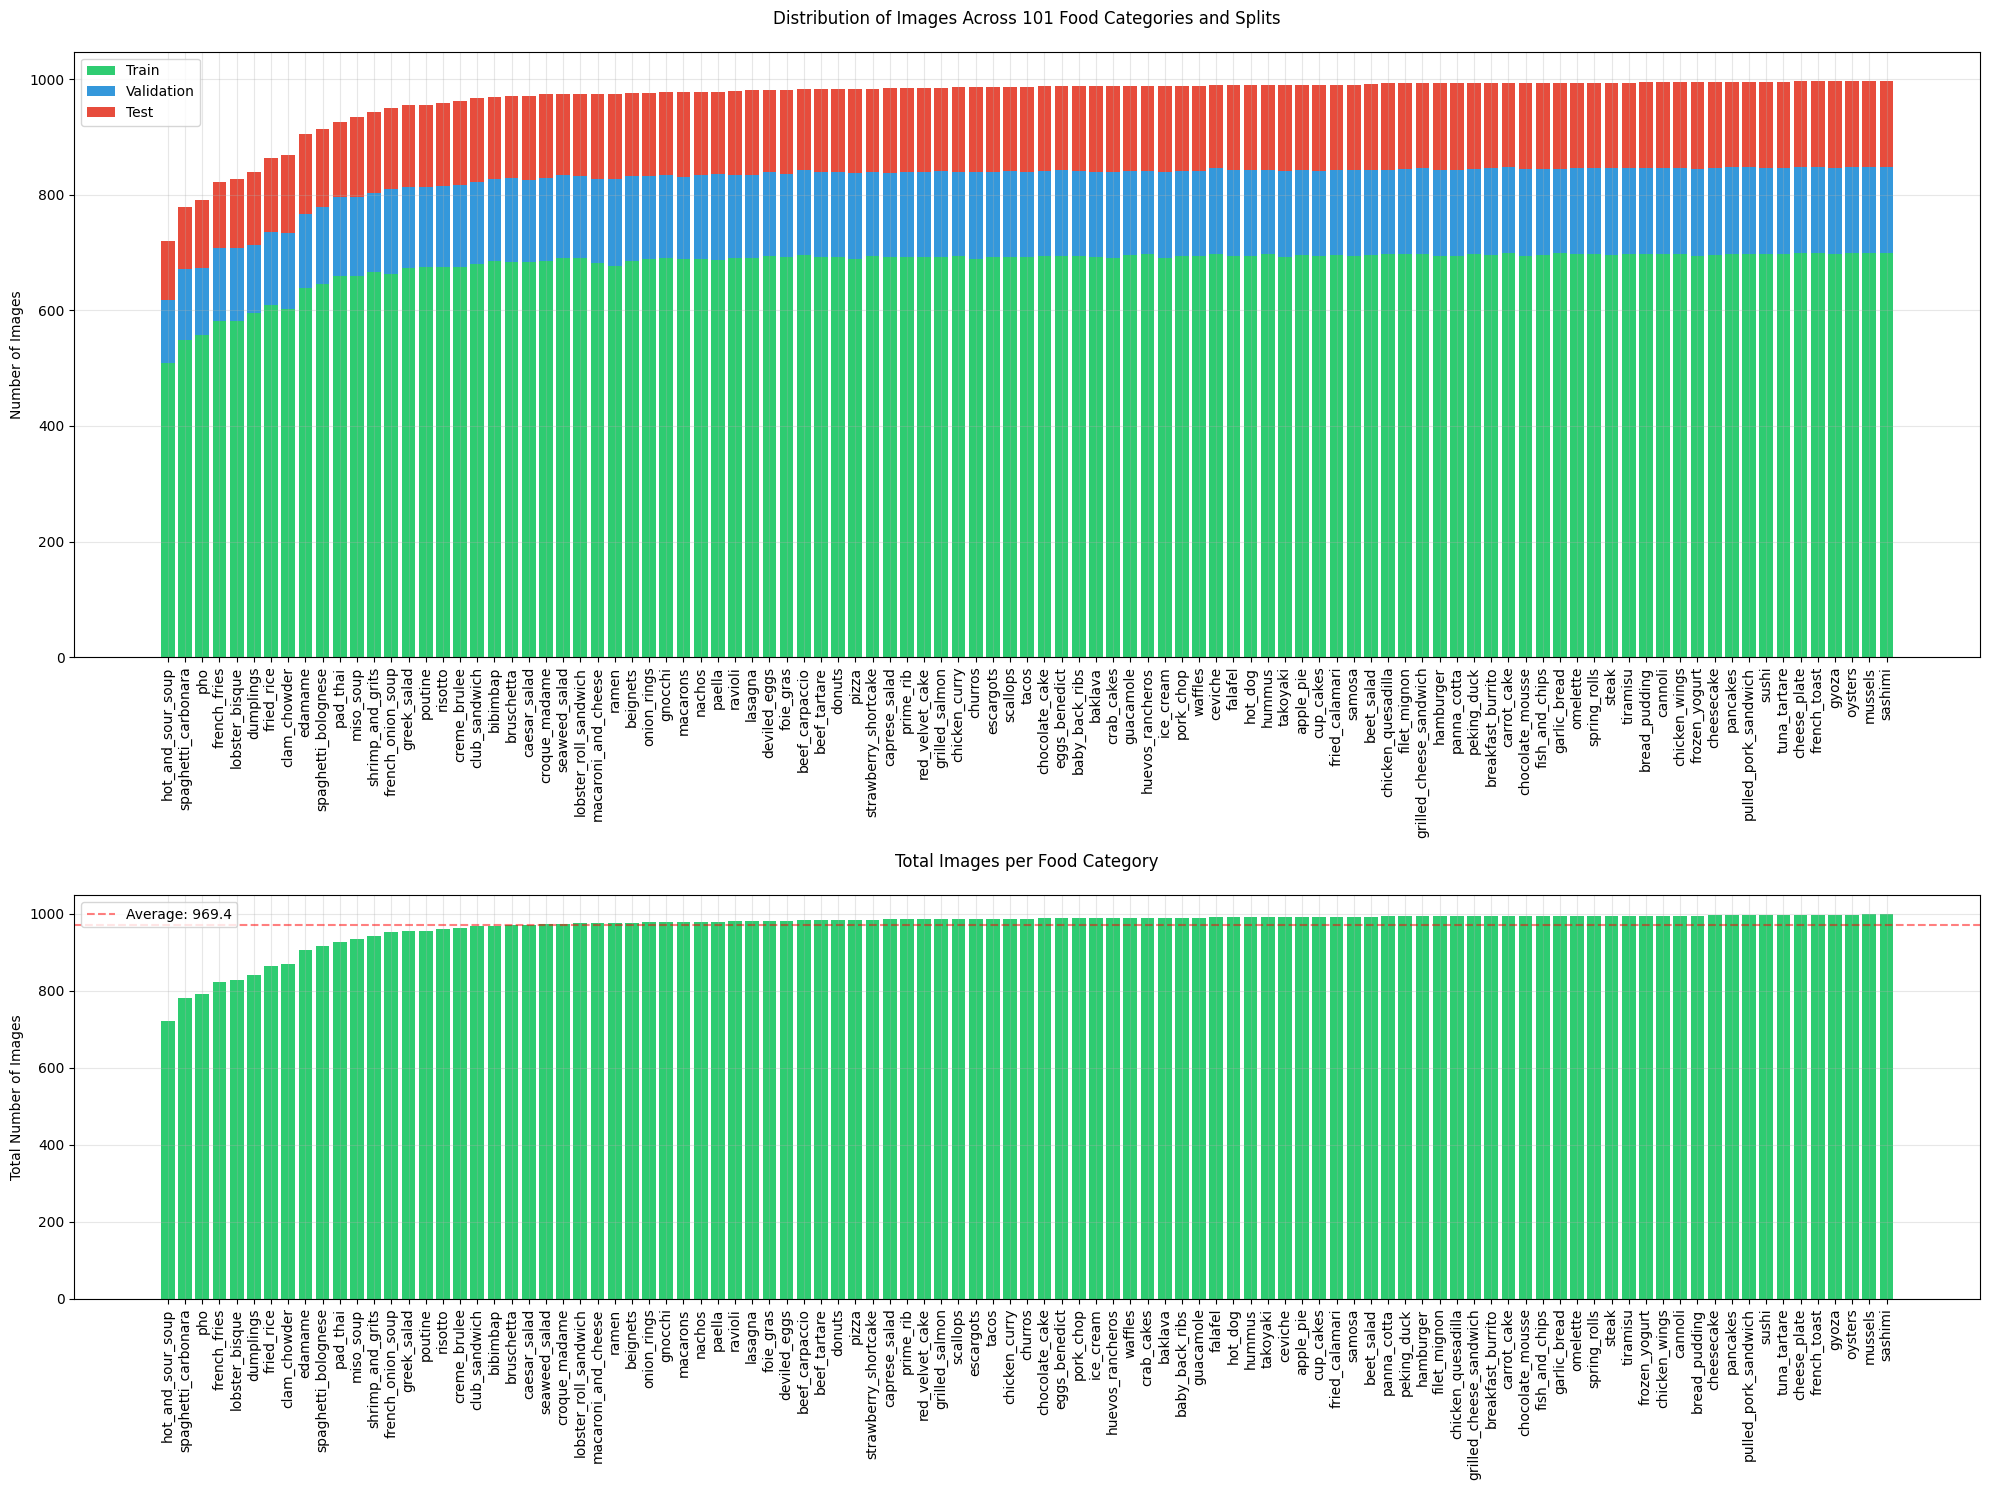

In [65]:
# Load and prepare the data
with open('distribution_data.json', 'r') as f:
    data = json.load(f)

# Convert to DataFrame
df = pd.DataFrame(data)

# Set figure size and font size for better visualization
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['font.size'] = 10

# Create two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, height_ratios=[1.5, 1])
fig.set_size_inches(20, 15)

# 1. Stacked Bar Plot for Split Distribution
bottom_val = df['train']
bottom_test = df['train'] + df['val']

ax1.bar(df['category'], df['train'], label='Train', color='#2ecc71')
ax1.bar(df['category'], df['val'], bottom=bottom_val, label='Validation', color='#3498db')
ax1.bar(df['category'], df['test'], bottom=bottom_test, label='Test', color='#e74c3c')

ax1.set_title('Distribution of Images Across 101 Food Categories and Splits', pad=20, fontsize=12)
ax1.tick_params(axis='x', rotation=90)
ax1.set_ylabel('Number of Images')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Total Distribution (Sorted)
df_sorted = df.sort_values('total')
ax2.bar(df_sorted['category'], df_sorted['total'], color='#2ecc71')
ax2.set_title('Total Images per Food Category', pad=20, fontsize=12)
ax2.tick_params(axis='x', rotation=90)
ax2.set_ylabel('Total Number of Images')
ax2.grid(True, alpha=0.3)

# Add average line
avg_total = df['total'].mean()
ax2.axhline(y=avg_total, color='red', linestyle='--', alpha=0.5, label=f'Average: {avg_total:.1f}')
ax2.legend()

# Adjust layout
plt.tight_layout()

# Print statistics
print("\nDataset Statistics:")
print(f"Total number of categories: {len(df)}")
print(f"Minimum images per category: {df['total'].min()}")
print(f"Maximum images per category: {df['total'].max()}")
print(f"Average images per category: {df['total'].mean():.2f}")

print("\nCategories with least images:")
print(df.nsmallest(5, 'total')[['category', 'total', 'train', 'val', 'test']].to_string(index=False))

print("\nCategories with most images:")
print(df.nlargest(5, 'total')[['category', 'total', 'train', 'val', 'test']].to_string(index=False))

# Show split distribution statistics
print("\nSplit Distribution Statistics:")
print("Training:")
print(f"  Min: {df['train'].min()}")
print(f"  Max: {df['train'].max()}")
print(f"  Mean: {df['train'].mean():.2f}")

print("\nValidation:")
print(f"  Min: {df['val'].min()}")
print(f"  Max: {df['val'].max()}")
print(f"  Mean: {df['val'].mean():.2f}")

print("\nTest:")
print(f"  Min: {df['test'].min()}")
print(f"  Max: {df['test'].max()}")
print(f"  Mean: {df['test'].mean():.2f}")

plt.show()

## Reference


- This code is heavely inspired from these notebooks
    - https://visual-layer.readme.io/docs/cleaning-image-dataset
    - https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/cleaning-image-dataset.ipynb
    - https://nbviewer.org/github/visual-layer/fastdup/blob/main/examples/analyzing-image-classification-dataset.ipynb